# MMLDT-CSET 2021

# Short course #:

# **Soblev training for hyperelastic energy function**

Instructors: Waiching Sun, Mian Xiao (Columbia University)

Programmer: Mian Xiao

## Outline

1. Data generation
2. Define the nerual network architecture
3. Batched data loader
4. Data scaling
5. The Sobolev training class
6. Run Sobolev training
7. Result visualization
8. Load test simulation


# Preliminaries

In this lecture, we are intersted in obtaining material constitutive relationships via machine learning via Tensorflow. Specifically, the hyperelastic energy function (isotropic) is expressed in an invariant form as follows:
$$ \psi = \psi^e(\varepsilon_v, \varepsilon_s) $$
where $\varepsilon_v, \varepsilon_s$ are the 1st and 2nd strain invariants such that:
$$ \varepsilon_v = \mathrm{tr}(\mathbf \varepsilon),\quad \varepsilon_s = \sqrt{\frac{2}{3}}|| \varepsilon^{\mathrm{dev}} || $$
where $\varepsilon^{\mathrm{dev}}=\varepsilon - \frac{\varepsilon_v}{3} I$

Defining the devatoric direction as: $n = \varepsilon^{\mathrm{dev}} / ||\varepsilon^{\mathrm{dev}}||$, one can recover the strain with the invariants $\varepsilon_v, \varepsilon_s$:
$$ \varepsilon = \frac{\varepsilon_v}{3} I + \sqrt{\frac{3}{2}}\varepsilon_s n $$

The invariant stresses w.r.t. $\varepsilon_v, \varepsilon_s$ are:
$$ p = \frac{\partial\psi}{\partial\varepsilon_v},\quad q = \frac{\partial\psi}{\partial\varepsilon_s} $$

Taking the derivaticves of $p$ and $q$ with respect to the elastic strain invariants
One can verify that for isotropic hyperelastic constitutive models, the stress can be recovered with the invariant stresses as follows:
$$ \sigma = \frac{\partial\psi}{\partial\varepsilon} = p I + \sqrt{\frac{2}{3}}q n $$


\math{D}

# 1. Data generation for the elastic energy functional

$$\mathcal{D}^{data}$$


For demonstration purpose, we first generate the ground true data from an analytical energy functional. However, the supervised learning should work for other types of point clouds in the parametric space.


Let's start with a linear elastic function:
$$ \psi = \frac{K}{2}\varepsilon_v^2 + \frac{3}{2}G\varepsilon_s^2 $$
where $K$ is the bulk modulus and $G$ is the shear modulus.

The entire set of data points scatters as a $50\times 50$ structured grid in the $\varepsilon_v$ - $\varepsilon_s$ plane. The range of $\varepsilon_v$ is $[-0.2, 0.2]$, and the range of $\varepsilon_s$ is $[0, 0.3]$ (notice that $\varepsilon_s \geq 0$ always). You may expand or shrink the data range as you wish.

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
from autograd import grad, hessian, jacobian
import pandas as pd

In [2]:
num_points = 50

# data range of ev, es
min_ev = -0.20
max_ev = 0.20
min_es = 0. # es is always positive
max_es = 0.30

E = 2.0799
nu = 0.3
K_bulk = E / 3. / (1. - 2. * nu)
G_shear = E / 2. / (1. + nu)

def getf(X,Y):
    """
    compute the elastic storage energy in invariant forms, inputs:
	    X is the volumetric strain
	    Y is the deviatoric strain
    returns:
      the elastic function value psi
    """
    return 0.5 * K_bulk * X * X   +  G_shear * Y * Y * 3/2

# use autograd to compute invariant stresses (derivatives w.r.t. strain)
p_func = egrad(getf,0) # p = d\psi / d ev
q_func = egrad(getf,1) # q = d\psi / d es
def getfp(X,Y):
    p = p_func(X,Y)
    q = q_func(X,Y)
    return p, q

# generate a grid of ev, es for training/testing
Xgrid, Ygrid = np.meshgrid(np.linspace(min_ev, max_ev, num_points), np.linspace(min_es, max_es, num_points))
XX = Xgrid.reshape(-1,1)
YY = Ygrid.reshape(-1,1)
# compute the energy and invariant stresses as the training/testing labels
psi = getf(XX,YY)
p, q = getfp(XX,YY)

# save all data
dataset = pd.DataFrame({'eps11': XX[:,0], 'eps22': YY[:,0], 'psi_e': psi[:,0], 'W_e11': p[:,0], 'W_e22': q[:,0]})
dataset.to_csv("hyperelastic_data.csv",index = False)

<Axes: >

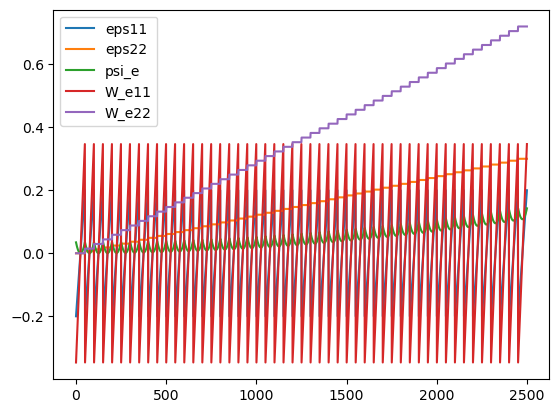

In [4]:
dataset.plot()

# Import necessary libraries

In [5]:
import numpy as np
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Multiply, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.losses import MSE
from tensorflow.keras.metrics import MeanSquaredError

import joblib
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

2023-07-03 15:07:34.544874: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Define the neural network architecture

The neural network architecture we adopt is a sequential deep feed-forward network with the following layers:

1.   Fully-connected hidden layer: 100 nerons, ReLu activation
2.   Element-wise multiply hidden layer
3.   Element-wise multiply hidden layer
4.   Fully-connected hidden layer: 100 nerons, ReLu activation
5.   Element-wise multiply hidden layer
6.   Fully-connected output layer: 1 neron, linear activation

Notice that in order to predict the stresses, it is important to evaluate the gradients of the energy function. A neural network fully composed of dense layers with ReLu activation may be akward in gradient calculation (because of derivative of ReLu is either 0 or 1). For a detailed explanation please refer to (Vlassis et al., 2020)

### GPTiño:

In the provided code, the Multiply layers are used for element-wise multiplication of tensors. Let's break down the purpose of these element-wise multiply hidden layers and understand their role in the DeepDenseNet model.

The DeepDenseNet model is a neural network architecture consisting of dense (fully connected) layers. The purpose of using element-wise multiplication layers in this model seems to be to introduce non-linear interactions between the features learned by the dense layers.

Here's a step-by-step explanation of how these element-wise multiply layers are used in the model:

- First, the x input is passed through the fc_layer_1, which is a dense layer with a ReLU activation function. This layer learns a set of weights and biases to transform the input into a new representation.

- Next, the output of fc_layer_1 is passed through the mult_layer_11 layer, where it is element-wise multiplied with itself. This multiplication operation allows the model to capture interactions between the features learned by fc_layer_1. Essentially, it amplifies the importance of certain features by multiplying them together.

- The output of mult_layer_11 is then passed through mult_layer_12, which performs another element-wise multiplication with itself. This additional multiplication further enhances the non-linear interactions between the features.

- The result of mult_layer_12 is then passed through fc_layer_2, another dense layer with a ReLU activation function. This layer performs a similar transformation as fc_layer_1, learning a new representation based on the interactions captured in the previous multiply layers.

- Following fc_layer_2, the output is again passed through mult_layer_21, which performs element-wise multiplication with itself. This multiplication further amplifies the non-linear interactions captured by the model.

- Finally, the output of mult_layer_21 is passed through fc_layer_3, which is the final dense layer with a linear activation function. This layer produces the final output of the model, which is a single scalar value.

By using these element-wise multiply layers, the model can capture non-linear interactions between the learned features at different stages of the network. This can help the model learn complex relationships in the data and potentially improve its predictive capabilities.

It's worth noting that the effectiveness and necessity of these element-wise multiply layers depend on the specific problem and dataset being addressed. They introduce additional non-linearity and interaction into the model, but their impact may vary depending on the task at hand.

In [6]:
"""
    Define the deep dense NN for training
"""
class DeepDenseNet(Model):
    def __init__(self, width=100):
        super(DeepDenseNet, self).__init__()
        self.fc_layer_1 = Dense(width, activation="relu", kernel_initializer='glorot_uniform')
        self.mult_layer_11 = Multiply()
        self.mult_layer_12 = Multiply()
        self.fc_layer_2 = Dense(width, activation='relu', kernel_initializer='glorot_uniform')
        self.mult_layer_21 = Multiply()
        self.fc_layer_3 = Dense(1, activation="linear", kernel_initializer='glorot_uniform', name = 'out')

    def call(self, x):
        h = self.fc_layer_1(x)
        h = self.mult_layer_11([h,h])
        h = self.mult_layer_12([h,h])
        h = self.fc_layer_2(h)
        h = self.mult_layer_21([h,h])
        out = self.fc_layer_3(h)
        return out

# 3. Batched data loader

For each gradient descend step during the training process, we need to prepare not only the training X and Y, but also the gradient of Y for supervision. Here we implement a batched data loader to generate batched X, Y and Y_grad for each feed-forward step with automatic random shuffle. We utilize the *iterator* features of python, please refer to the following links for more information:

[https://www.geeksforgeeks.org/iterators-in-python](https://www.geeksforgeeks.org/iterators-in-python/)

In [7]:
"""
    customed data generator, which prepares the X, Y and Y_grad for training/testing purpose
"""
class BatchGenerator(object):
    def __init__(self, X, y, y_grad):
        self.X = X
        self.y = y
        self.y_grad = y_grad
        self.N = y.shape[0]
        self.N_features = X.shape[1]

    def next_batch_gen(self, batch_size, shuffle=True):
        num_batches = self.N // batch_size
        n_features = self.N_features
        bch = 0
        while True:
            if bch < num_batches:
                bch += 1
                yield self.X[bch*batch_size : (bch+1)*batch_size, :],\
                      self.y[bch*batch_size : (bch+1)*batch_size],\
                      self.y_grad[bch*batch_size : (bch+1)*batch_size, :]
            else:
                bch = 0
                all_data = tf.concat([self.X, self.y, self.y_grad], axis=1)
                all_data = tf.random.shuffle(all_data)
                self.X, self.y, self.y_grad = tf.split(all_data,\
                    [n_features, 1, n_features], axis=1)

# 4. Scaling the data

Data scaling is a practical technique that improves the performance of neural network prediction. In this lecture, we adopt *scikit-learn* implementation of the min-max scaler that cast the data in to a range of [0,1]:
$$ \overline{X} = \frac{X - X_{\mathrm{min}}}{ X_{\mathrm{max}} - X_{\mathrm{min}} },\quad \overline{Y} = \frac{Y - Y_{\mathrm{min}}}{ Y_{\mathrm{max}} - Y_{\mathrm{min}} },\quad \overline{Y}_g = \frac{Y_g - Y_{g,\mathrm{min}}}{ Y_{g,\mathrm{max}} - Y_{g,\mathrm{min}} } $$
where the overline indicates that the value is normalized with a min-max scaler.

Notice that *sklearn.preprocessing.MinMaxScaler* defines the *scale_* and *min* in the following fashion:
$$ \mathrm{scale\_}(X) = \frac{1}{X_{\mathrm{max}} - X_{\mathrm{min}}} $$
$$ \mathrm{min\_}(X) = -X_{\mathrm{min}} * \mathrm{scale} $$

You may also refer to [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for details of *MinMaxScaler*:



In [9]:
# read data
DataFrame = pd.read_csv('hyperelastic_data.csv')

# ------------------------------
# Scale the data to range(0,1)
# ------------------------------

# scale inputs
inp = DataFrame[["eps11", "eps22"]]
inp_scaler = MinMaxScaler()
inp_scaled = inp_scaler.fit_transform(inp)
scales_inp = inp_scaler.scale_
joblib.dump(inp_scaler, 'INPUT_Scaler.pkl')

# scale output
out = DataFrame[["psi_e"]]
out_scaler = MinMaxScaler()
out_scaled = out_scaler.fit_transform(out)
scales_out = 1. / out_scaler.scale_
joblib.dump(out_scaler, 'OUTPUT_Scaler.pkl')

# scale grads
grad = DataFrame[["W_e11","W_e22"]].values.reshape(-1,2)
grad_scaler = MinMaxScaler()
grad_scaled = grad_scaler.fit_transform(grad)
scales_grad = grad_scaler.scale_
limits_grad =  grad_scaler.min_
joblib.dump(grad_scaler, 'GRAD_Scaler.pkl')



['GRAD_Scaler.pkl']

# 5. The Sobolev training


Assume that the neural network will build the relationship between the processed data:
$$ \hat{ \overline{Y} } = f(\overline{X}) $$

We use the following formula to compute the energy functional derivative with the neural network derivative:
$$ \hat{Y}_g := \frac{\partial\hat{Y}}{\partial X} = \frac{\partial\hat{Y}}{\partial\hat{\overline{Y}}} \frac{\partial\hat{\overline{Y}}}{\partial\overline{X}} \frac{\partial\overline{X}}{\partial X} $$

We can evaluate $\frac{\partial\hat{Y}}{\partial\hat{\overline{Y}}}$ and $\frac{\partial\overline{X}}{\partial X}$ from the scales in the data preprocessing:
$$ \frac{\partial\hat{Y}}{\partial\hat{\overline{Y}}} = 1/ \frac{\partial\hat{\overline Y}}{\partial\hat{Y}} = 1 / \mathrm{scale\_}(\hat{Y}),\quad \frac{\partial\overline{X}}{\partial X} = \mathrm{scale\_}(X) $$
and evaluate $\frac{\partial\hat{\overline{Y}}}{\partial\overline{X}}$ with neural network gradient w.r.t. the neural network input.



*   To apply Sobolev training on our custom neural network, we adopt the following loss function (Vlassis et al., 2021):
$$ \mathcal{L} = \mathcal{L}_{\mathrm{val}} + \mathcal{L}_{\mathrm{grad}},\quad \mathcal{L}_{\mathrm{val}} = || \overline{Y} - \hat{\overline{Y}} ||^2, \mathcal{L}_{\mathrm{grad}} = || \overline{Y}_g - \hat{\overline{Y}}_g ||^2 $$
*   The dataset is split into a training set and a validation set by a ratio of 8:2.
*   We use the Adam optimization algorithm.



In [10]:
class Sobolev_trainer():
    def __init__(self, X, y, y_grad, net_width=100, valid_split=0.2, epochs=100, batch_size=128, lr=1e-2):
        """
          X: Inputs. It should be a 2D array like (n_samples, n_features).
          y: Supervised values (free energy). It should be a 1D vector like (n_samples, )
          y_grad: Supervised gradients (stresses). It should be a 2D array (n_samples, n_features)
          y_hess: Supervised hessians (tangent). It should be a 2D array (n_samples, n_features*n_features)
          epochs: Number of training epochs
          batch_size: batch_size while training
          lr: learning rate of optimizer
        """
        self.valid_split = valid_split
        self.N_features = X.shape[1]
        N_train = int((1. - valid_split) * y.shape[0])
        self.N_train = N_train
        # shuffle all samples before validation split
        p = np.random.permutation(y.shape[0])
        X = tf.convert_to_tensor(X[p, :])
        y = tf.convert_to_tensor(y[p])
        y_grad = tf.convert_to_tensor(y_grad[p,:])
        # split the samples into train and valid sets
        self.X_train = X[0:N_train, :]
        self.y_train = y[0:N_train]
        self.y_grad_train = y_grad[0:N_train, :]
        self.X_valid = X[N_train:, :]
        self.y_valid = y[N_train:]
        self.y_grad_valid = y_grad[N_train:, :]

        # other training config
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.print_interval = 10

        # Initialize MyLenet model
        self.model = DeepDenseNet(net_width)
        #self.model.summary()

        #initialize loss function and metrics to track over training
        self.loss_function = MSE
        self.train_val_loss  = MeanSquaredError(name='train_val_loss')
        self.train_grad_loss = MeanSquaredError(name='train_grad_loss')
        self.valid_val_loss  = MeanSquaredError(name='valid_val_loss')
        self.valid_grad_loss = MeanSquaredError(name='valid_grad_loss')
        # record training history
        self.history = {'train_val_loss':[], 'train_grad_loss':[],\
            'valid_val_loss':[], 'valid_grad_loss':[]}

        # Initialize optimizer
        self.optimizer = Adam(learning_rate=self.lr)

    # setup scales during preprocessing of data
    def setup_scales(self, scales):
        self.scales = scales

    # Prepare batches of train data using ImageGenerator
    def batch_train_data(self, shuffle=True):
        train_data = BatchGenerator(self.X_train, self.y_train, self.y_grad_train)
        self.train_data_next_batch = train_data.next_batch_gen(self.batch_size, shuffle=shuffle)
        self.n_batches = train_data.N // self.batch_size

    # Sobolev training step
    def train_step(self, inputs, values, gradients):
        n_features = self.N_features
        scales_inp = self.scales[0]
        scales_out = self.scales[1]
        scales_grad = self.scales[2]
        limits_grad = self.scales[3]

        with tf.GradientTape(persistent=True) as tape_l:
            tape_l.watch(self.model.trainable_variables)
            # inner gradient tapes has something to do with model grad
            with tf.GradientTape(persistent=True) as tape_g:
                tape_g.watch(inputs)
                preds = self.model(inputs, training=True)
            # compute model gradients
            model_grad = tape_g.gradient(preds, inputs)
            # scale to the original magnitude of stresses
            model_grad = scales_out * model_grad * scales_inp
            # convert the stress scales back to (0,1)
            model_grad = model_grad * scales_grad + limits_grad
            loss = 1. * MSE(values, preds) + 1. * MSE(gradients, model_grad)
        param_grads = tape_l.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(param_grads, self.model.trainable_variables))

        self.train_val_loss . update_state(values, preds)
        self.train_grad_loss. update_state(gradients, model_grad)

    # Define testing step
    def test_step(self, inputs, values, gradients):
        n_features = self.N_features
        scales_inp = self.scales[0]
        scales_out = self.scales[1]
        scales_grad = self.scales[2]
        limits_grad = self.scales[3]

        with tf.GradientTape(persistent=True) as tape_g:
            tape_g.watch(inputs)
            preds = self.model(inputs, training=True)
        # compute model gradients
        model_grad = tape_g.gradient(preds, inputs)
        # scale to the original magnitude of stresses
        model_grad = scales_out * model_grad * scales_inp
        # convert the stress scales back to (0,1)
        model_grad = model_grad * scales_grad + limits_grad

        self.valid_val_loss . update_state(values, preds)
        self.valid_grad_loss. update_state(gradients, model_grad)

    # train epoch
    def train_epoch(self, epoch):
        self.train_val_loss . reset_states()
        self.train_grad_loss. reset_states()
        self.valid_val_loss . reset_states()
        self.valid_grad_loss. reset_states()

        if (epoch+1) % self.print_interval == 0:
            print('Training Epoch {}'.format(epoch + 1))
        # train_step
        for bch in range(self.n_batches):
            X_batch, y_batch, y_grad_batch = next(self.train_data_next_batch)
            self.train_step(X_batch, y_batch, y_grad_batch)

        # valid step
        self.test_step(self.X_valid, self.y_valid, self.y_grad_valid)
        # record epoch history
        history = self.history
        history['train_val_loss'] .append( self.train_val_loss . result().numpy() )
        history['train_grad_loss'].append( self.train_grad_loss. result().numpy() )
        history['valid_val_loss'] .append( self.valid_val_loss . result().numpy() )
        history['valid_grad_loss'].append( self.valid_grad_loss. result().numpy() )
        # print training histories
        template  = 'train_val_loss: {}, train_grad_loss: {}, '
        template += 'valid_val_loss: {}, valid_grad_loss: {}.'
        if (epoch+1) % self.print_interval == 0:
            print(template.format(history['train_val_loss'] [-1],\
                history['train_grad_loss'][-1],\
                history['valid_val_loss'] [-1],\
                history['valid_grad_loss'][-1]))

    # start training
    def run(self):
        self.batch_train_data()
        for epoch in range(self.epochs):
            self.train_epoch(epoch)


# 6. Train the model

Try a training configuration with 100 epochs, a data batch size of 64 and a learning rate of 1e-3. You may tune these hyperparameters to optimize the model performance on the generated dataset.

In [11]:
# run Sobolev training
sb_train = Sobolev_trainer(inp_scaled, out_scaled, grad_scaled, epochs=100, batch_size=64, lr=1e-3)
sb_train.setup_scales([scales_inp, scales_out, scales_grad, limits_grad])
sb_train.run()

2023-07-03 15:59:38.428089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 15:59:38.430210: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Training Epoch 10
train_val_loss: 0.002852322041423828, train_grad_loss: 0.010166727244802122, valid_val_loss: 0.002684506148319917, valid_grad_loss: 0.008495018126931693.
Training Epoch 20
train_val_loss: 0.0002635395857133826, train_grad_loss: 0.0015039168224630834, valid_val_loss: 0.0003549445411878285, valid_grad_loss: 0.001879679028859021.
Training Epoch 30
train_val_loss: 5.423883077941491e-05, train_grad_loss: 0.00038669386006390716, valid_val_loss: 5.320632415292623e-05, valid_grad_loss: 0.0003206364493098179.
Training Epoch 40
train_val_loss: 1.625156180067266e-05, train_grad_loss: 0.0001608870772948307, valid_val_loss: 1.5100074965922236e-05, valid_grad_loss: 0.00014411352974348234.
Training Epoch 50
train_val_loss: 1.2719537082845167e-05, train_grad_loss: 0.00010664230806588445, valid_val_loss: 4.667990744682847e-06, valid_grad_loss: 8.50347709923859e-05.
Training Epoch 60
train_val_loss: 4.494741041860546e-06, train_grad_loss: 6.61016458328214e-05, valid_val_loss: 1.1283056

# 7. Visualize the prediction

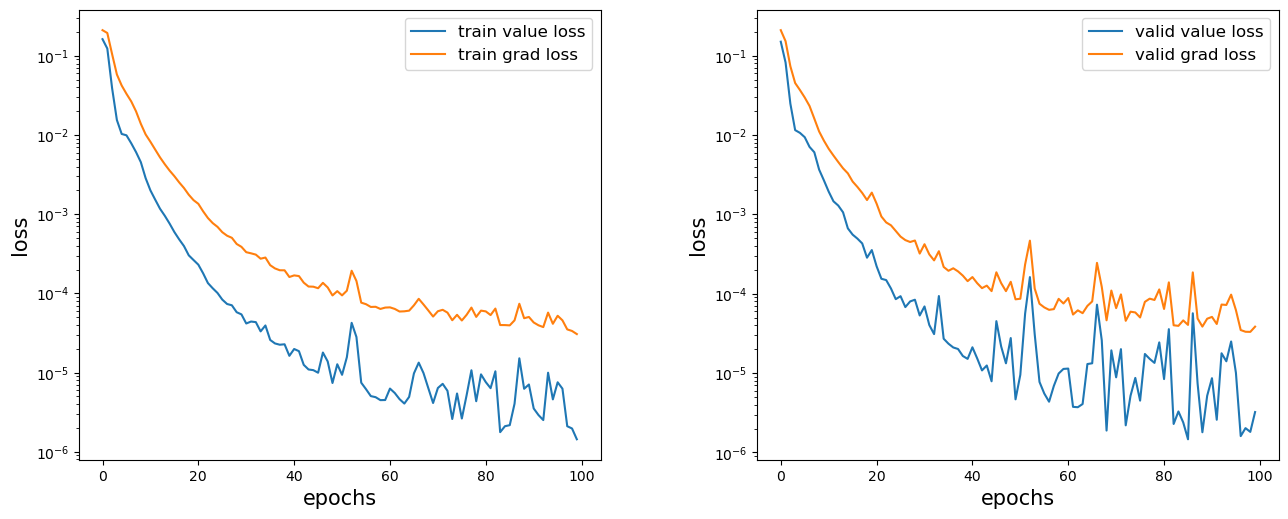

In [12]:
"""
    show training loss history
"""
def plot_history(train_history):
    fig, axs = plt.subplots(1, 2, figsize=(15,6))
    ax = axs[0]
    ax.semilogy(train_history['train_val_loss'], label='train value loss')
    ax.semilogy(train_history['train_grad_loss'], label='train grad loss')
    ax.set_xlabel("epochs", fontsize=15)
    ax.set_ylabel("loss", fontsize=15)
    ax.legend(fontsize=12)

    ax = axs[1]
    ax.semilogy(train_history['valid_val_loss'], label='valid value loss')
    ax.semilogy(train_history['valid_grad_loss'], label='valid grad loss')
    ax.set_xlabel("epochs", fontsize=15)
    ax.set_ylabel("loss", fontsize=15)
    ax.legend(fontsize=12)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.show()

plot_history(sb_train.history)

In [13]:
"""
    predict on a new set of data
"""
# generate a grid of ev, es for training/testing
num_test_points = 44
X_test, Y_test = np.meshgrid(np.linspace(min_ev, max_ev, num_test_points), np.linspace(min_es, max_es, num_test_points))
# compute the energy and invariant stresses as the training/testing labels
test_inp = np.concatenate((X_test.reshape(-1,1), Y_test.reshape(-1,1)), axis=1)
psi_true = getf(test_inp[:,0], test_inp[:,1])
p_true, q_true = getfp(test_inp[:,0], test_inp[:,1])

# NN prediction
def nn_predict_h1(model, inp):
    inp_tf = tf.convert_to_tensor( inp_scaler.transform(inp) )
    # get energy value and the gradients and scale them to the original stress scale
    with tf.GradientTape(persistent=True) as tape_g:
        tape_g.watch(inp_tf)
        psi_pred = model(inp_tf)
    grads_pred = tape_g.gradient( psi_pred, inp_tf )
    grads_pred = scales_out * grads_pred * scales_inp

    psi_pred = out_scaler.inverse_transform( psi_pred.numpy() )
    p_pred = grads_pred.numpy()[:,0:1]
    q_pred = grads_pred.numpy()[:,1:2]
    return psi_pred, p_pred, q_pred

psi_pred, p_pred, q_pred = nn_predict_h1(sb_train.model, test_inp)

/home/hector/miniconda3/envs/MMLDT/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


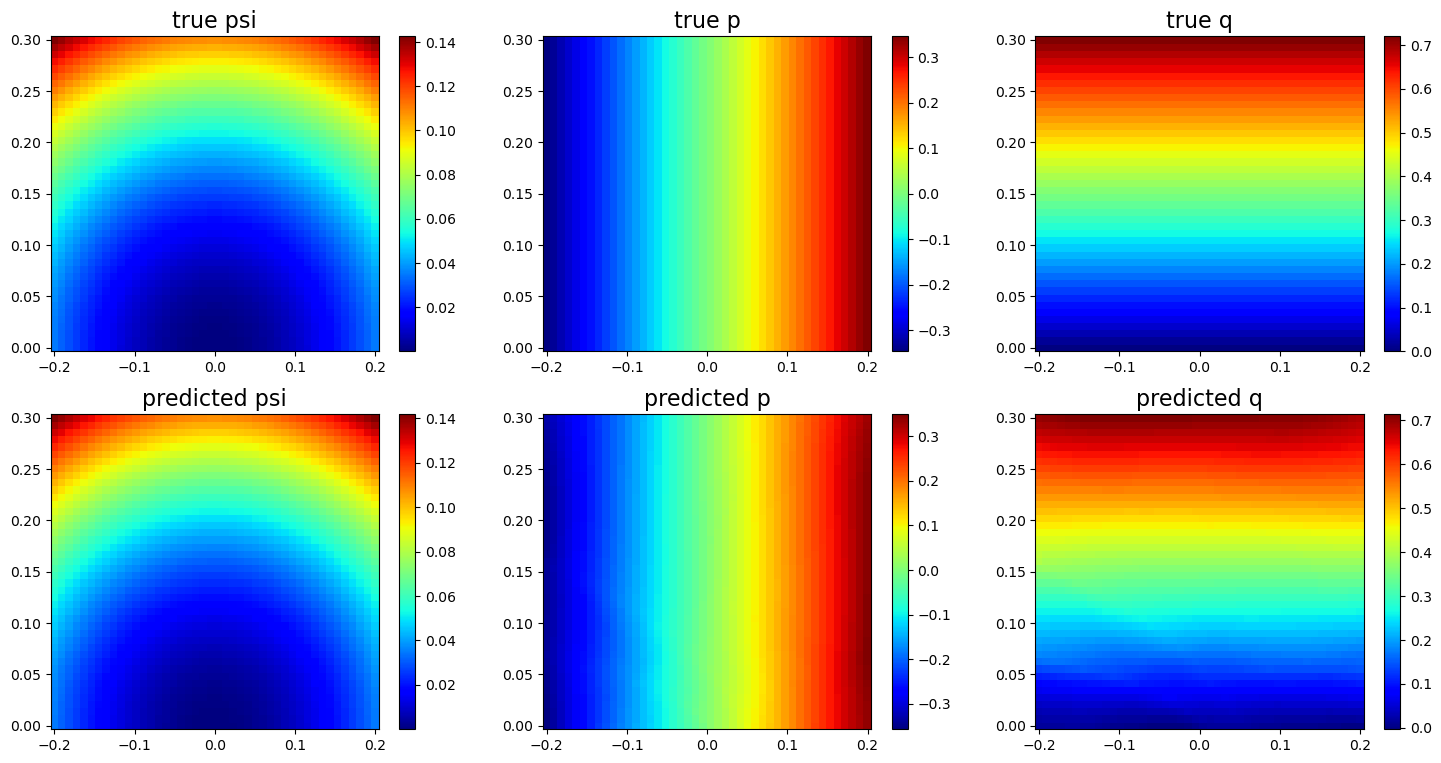

In [14]:
"""
    show the energy function value and gradient prediction
"""
def plot_2d_prediction(X, Y, psi_true, p_true, q_true, psi_pred, p_pred, q_pred):
    fig, axs = plt.subplots(2, 3, figsize=(18, 9),\
        gridspec_kw={'wspace': 0.2, 'hspace': 0.2})

    ax = axs[0,0]
    c = ax.pcolor(X, Y, psi_true.reshape(num_test_points, num_test_points), cmap='jet')
    ax.set_title('true psi', fontsize=16)
    fig.colorbar(c, ax=ax)

    ax = axs[0,1]
    c = ax.pcolor(X, Y, p_true.reshape(num_test_points, num_test_points), cmap='jet')
    ax.set_title('true p', fontsize=16)
    fig.colorbar(c, ax=ax)

    ax = axs[0,2]
    c = ax.pcolor(X, Y, q_true.reshape(num_test_points, num_test_points), cmap='jet')
    ax.set_title('true q', fontsize=16)
    fig.colorbar(c, ax=ax)

    ax = axs[1,0]
    c = ax.pcolor(X, Y, psi_pred.reshape(num_test_points, num_test_points), cmap='jet')
    ax.set_title('predicted psi', fontsize=16)
    fig.colorbar(c, ax=ax)

    ax = axs[1,1]
    c = ax.pcolor(X, Y, p_pred.reshape(num_test_points, num_test_points), cmap='jet')
    ax.set_title('predicted p', fontsize=16)
    fig.colorbar(c, ax=ax)

    ax = axs[1,2]
    c = ax.pcolor(X, Y, q_pred.reshape(num_test_points, num_test_points), cmap='jet')
    ax.set_title('predicted q', fontsize=16)
    fig.colorbar(c, ax=ax)
    plt.show()

plot_2d_prediction(X_test, Y_test, psi_true, p_true, q_true, psi_pred, p_pred, q_pred)

# 8. Run a loading test!

Here we would like to simulate a lateral-confined loading test in a constant loading rate $\dot{\varepsilon} = \left[ \begin{matrix} 2\times10^{-4} & 0 & 0 & 0 & 0 & 0 \end{matrix} \right]^T$ (where the strain is expressed in Voigt notation: $\left[ \begin{matrix} \varepsilon_{xx} & \varepsilon_{yy} & \varepsilon_{zz} & 2\varepsilon_{yz} & 2\varepsilon_{zx} & 2\varepsilon_{xy} \end{matrix} \right]$). We load for 1000 steps, each step for 1 second, such that the final strain $\varepsilon_{xx} = 0.2$.

/home/hector/miniconda3/envs/MMLDT/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


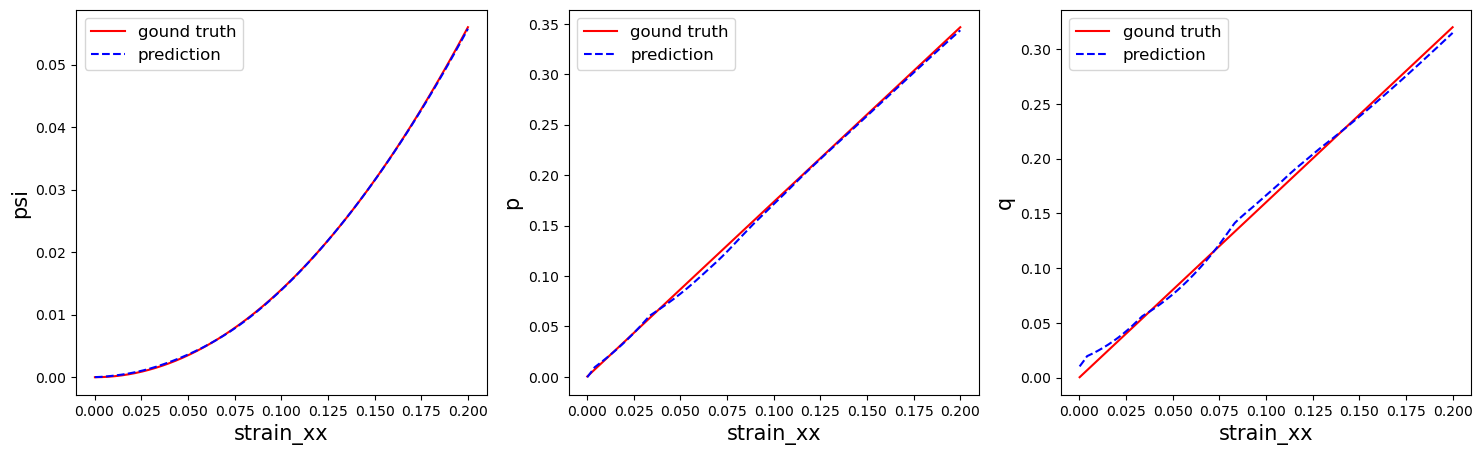

In [15]:
"""
  compute traces of strains:
  Input: N x 6 array, where each row is a strain vector (Voigt notation)
"""
def trace(strain):
    return strain[:,0:3].sum(axis=1).reshape(-1,1)

"""
  compute the devatoric part of strains
"""
def deviator(strain):
    strain_vol = np.zeros_like(strain)
    strain_vol[:,0:3] = trace(strain).repeat(3, axis=1)
    return strain - strain_vol/3

"""
  compute the Frobenius norm of strains
"""
def norm_fro(strain):
    return np.sqrt( (strain[:,0:3] * strain[:,0:3]).sum(axis=1) + .5*(strain[:,3:] * strain[:,3:]).sum(axis=1) ).reshape(-1,1)

# generate the strain loading history
n_loadsteps = 1000
strain_rate = 2e-4
strain_hist = np.zeros((n_loadsteps,6))
strain_hist[:,0] = strain_rate * np.arange(1,n_loadsteps+1)

# compute strain invariants for all steps
ev_hist = trace(strain_hist)
es_hist = np.sqrt(2/3) * norm_fro( deviator(strain_hist) )

# gorund truth values of energy and stresses
psi_hist_true = getf(ev_hist, es_hist)
p_hist_true, q_hist_true = getfp(ev_hist, es_hist)

# prepare NN prediction inputs
test_inp = np.concatenate((ev_hist, es_hist), axis=1)
psi_hist_pred, p_hist_pred, q_hist_pred = nn_predict_h1(sb_train.model, test_inp)

fig, axs = plt.subplots(1, 3, figsize=(18,5),\
        gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
ax = axs[0]
ax.plot(strain_hist[:,0], psi_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], psi_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("strain_xx", fontsize=15)
ax.set_ylabel("psi", fontsize=15)
ax.legend(fontsize=12)

ax = axs[1]
ax.plot(strain_hist[:,0], p_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], p_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("strain_xx", fontsize=15)
ax.set_ylabel("p", fontsize=15)
ax.legend(fontsize=12)

ax = axs[2]
ax.plot(strain_hist[:,0], q_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], q_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("strain_xx", fontsize=15)
ax.set_ylabel("q", fontsize=15)
ax.legend(fontsize=12)

# (Optional) Inject noise into the training data

In realistic modeling, we are not guaranteed that the collected data is error-free. Therefore, it is important to show that the neural network constitutive model is robust enough. For this reason, we will figure out how random noises affect the performance of the machine learning model.

In this section, we will pertube the training Y by a random noise, which is sampled from a Gaussian distribution $\mathcal{N} (0, \epsilon\Sigma)$, where $\Sigma$ is the standard deviation of the data and $\epsilon$ is a parameter indicating the magnitude of noise. The randome noise values sampled from $\mathcal{N}$ is then processed with a 2D Gaussian filter in order to generate a random noise field.

We can try with $\epsilon = 5$. You may change the value of $\epsilon$ or the standard deviation of the Gaussian filter as you wish.

/tmp/ipykernel_419849/1552525952.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


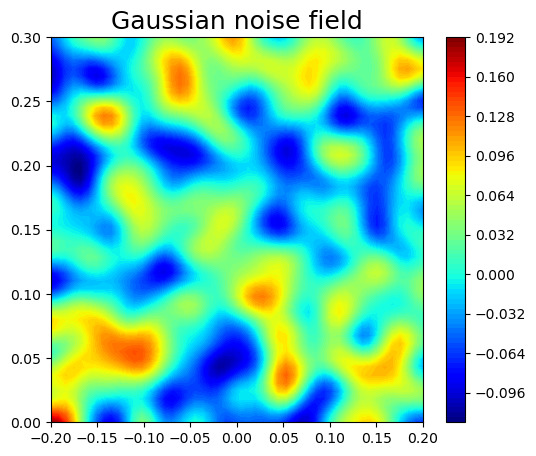

/home/hector/miniconda3/envs/MMLDT/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [16]:
# filter to generate Gaussian noise
from scipy.ndimage.filters import gaussian_filter

add_noise = True
noise_magnitude = 10
noise_ = np.random.normal(0, np.std(psi) * noise_magnitude, (num_points,num_points))
noise_ = gaussian_filter(noise_, sigma=2)
# show the noise field
fig, ax = plt.subplots(1, 1, figsize=(6,5),\
        gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
c = ax.contourf(Xgrid, Ygrid, noise_, 100, cmap='jet')
ax.set_title('Gaussian noise field', fontsize=18)
fig.colorbar(c, ax=ax)
plt.show();
noise_ = noise_.reshape(-1,1)

if add_noise:
    """
      find the std deviation for the energy and stress data
      Then inject random noise satisfying the following Gaussian distribution:
      N(0, stddev/10)
    """
    psi_pert = psi + noise_ * np.std(psi)
    p_pert = p + noise_ * np.std(p)
    q_pert = q + noise_ * np.std(q)
    out_pert = np.copy(psi_pert)
    grad_pert = np.concatenate((p_pert,q_pert), axis=1)

# scale output again
out_pert_scaled = out_scaler.transform(out_pert)
# scale grads again
grad_pert_scaled = grad_scaler.transform(grad_pert)

Training Epoch 10
train_val_loss: 0.003512017381976404, train_grad_loss: 0.010825329115384046, valid_val_loss: 0.0029806987485724167, valid_grad_loss: 0.008713870860495878.
Training Epoch 20
train_val_loss: 0.0003736925784164453, train_grad_loss: 0.0011690575075953918, valid_val_loss: 0.0003327325591876108, valid_grad_loss: 0.0011710568177797022.
Training Epoch 30
train_val_loss: 0.00018392601439539636, train_grad_loss: 0.0004247818079976767, valid_val_loss: 0.00018013105876671026, valid_grad_loss: 0.0004232517182255434.
Training Epoch 40
train_val_loss: 0.00019319705300769108, train_grad_loss: 0.00039758336746567634, valid_val_loss: 0.0002242994702054731, valid_grad_loss: 0.0007287130841005355.
Training Epoch 50
train_val_loss: 0.0001903820178428828, train_grad_loss: 0.00034669621332810894, valid_val_loss: 0.0001611094208592601, valid_grad_loss: 0.0002725757817846906.
Training Epoch 60
train_val_loss: 0.00020543294053858353, train_grad_loss: 0.00036340729280646267, valid_val_loss: 0.0

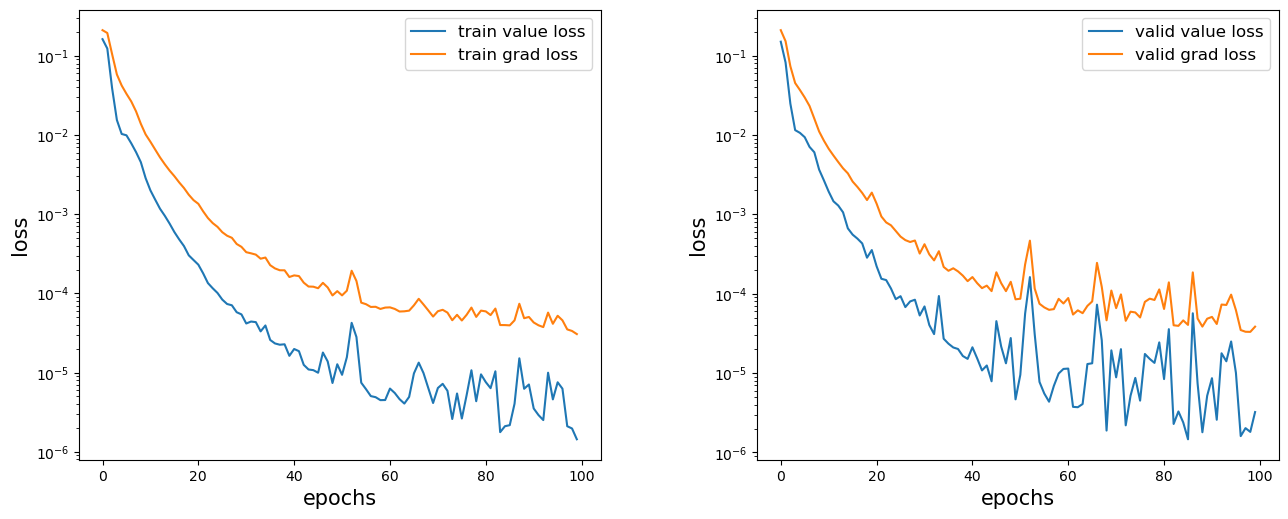

In [17]:
# train with the pertubed data, using the same configuration as section #6
sb_train_1 = Sobolev_trainer(inp_scaled, out_pert_scaled, grad_pert_scaled, epochs=100, batch_size=64, lr=1e-3)
sb_train_1.setup_scales([scales_inp, scales_out, scales_grad, limits_grad])
sb_train_1.run()
plot_history(sb_train.history)

Now test the trained model with noisy labels on the same loading path we have in Section #8. On the loading test, the ground truth is pertubed.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


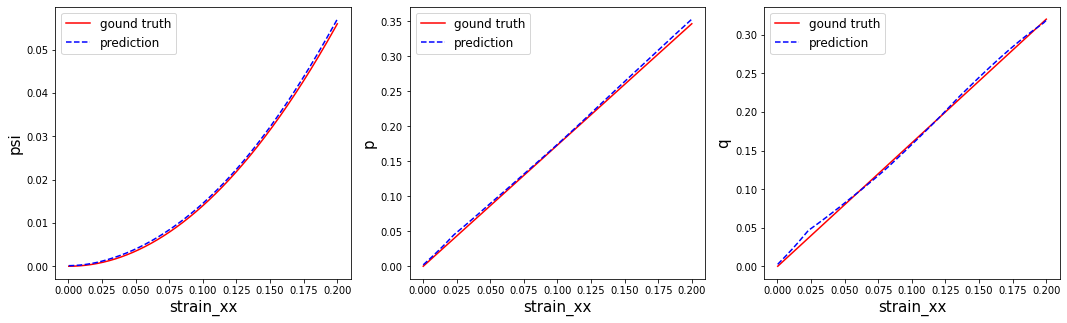

In [ ]:
test_inp = np.concatenate((ev_hist, es_hist), axis=1)
psi_hist_pred, p_hist_pred, q_hist_pred = nn_predict_h1(sb_train_1.model, test_inp)

fig, axs = plt.subplots(1, 3, figsize=(18,5),\
        gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
ax = axs[0]
ax.plot(strain_hist[:,0], psi_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], psi_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("strain_xx", fontsize=15)
ax.set_ylabel("psi", fontsize=15)
ax.legend(fontsize=12)

ax = axs[1]
ax.plot(strain_hist[:,0], p_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], p_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("strain_xx", fontsize=15)
ax.set_ylabel("p", fontsize=15)
ax.legend(fontsize=12)

ax = axs[2]
ax.plot(strain_hist[:,0], q_hist_true[:,0], 'r-', label='gound truth')
ax.plot(strain_hist[:,0], q_hist_pred[:,0], 'b--', label='prediction')
ax.set_xlabel("strain_xx", fontsize=15)
ax.set_ylabel("q", fontsize=15)
ax.legend(fontsize=12)

# References



1.   Vlassis, N. N., Ma, R., & Sun, W. (2020). Geometric deep learning for computational mechanics part i: Anisotropic hyperelasticity. Computer Methods in Applied Mechanics and Engineering, 371, 113299.
2.   Vlassis, N. N., & Sun, W. (2021). Sobolev training of thermodynamic-informed neural networks for interpretable elasto-plasticity models with level set hardening. Computer Methods in Applied Mechanics and Engineering, 377, 113695.

